In [1]:
import warnings
warnings.filterwarnings('ignore')

### Run in collab
<a href="https://colab.research.google.com/github/racousin/rl_introduction/blob/master/notebooks/3_Temporal_Difference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# uncomment 2 lines
#!git clone https://github.com/racousin/rl_introduction.git
#from rl_introduction.rl_introduction.tools import Agent, plot_values_lake, policy_evaluation, value_iteration, discount_cumsum, run_experiment_episode_train

### Run locally

In [3]:
from rl_introduction.tools import Agent, plot_values_lake, policy_evaluation, value_iteration, discount_cumsum, MyRandomAgent, run_experiment_episode_train

/home/raphael/rl_introduction/venv/lib/python3.7/site-packages/ale_py/roms/__init__.py:94: DeprecationWarning: Automatic importing of atari-py roms won't be supported in future releases of ale-py. Please migrate over to using `ale-import-roms` OR an ALE-supported ROM package. To make this warning disappear you can run `ale-import-roms --import-from-pkg atari_py.atari_roms`.For more information see: https://github.com/mgbellemare/Arcade-Learning-Environment#rom-management
  _RESOLVED_ROMS = _resolve_roms()



# 3_Temporal_Difference

### Objective
Here we present methods to solve the problem of environment and agents when the model is not known.

In [4]:
import numpy as np
import gym
import matplotlib.pyplot as plt
env = gym.make('FrozenLake-v1')

run_experiment_episode_train will be the function used to interact and learn from environment

In [5]:
def run_experiment_episode_train(env, agent, nb_episode):
    rewards = np.zeros(nb_episode)
    for i in range(nb_episode):
        state = env.reset()
        done = False
        rews = []
        while done is False:
            action = agent.act(state)
            current_state = state
            state, reward, done, info = env.step(action)
            agent.train(current_state, action, reward, state, done) # agent need a train method
            rews.append(reward)
        rewards[i] = sum(rews)
        print('episode: {} - cum reward {}'.format(i, rewards[i]))
    return rewards

# Usefull tools
Many times, it will be necessary to calculate the discount return $G_t = \sum_{k=0}^T\gamma^k R_{t+k+1}$. For that, we use optimized discount_cumsum function. Example

In [6]:
episode_reward = [0,0,0,1,0,0,0,-.3,0,1,1,0,10]
gamma = 0.9
discount_cumsum(episode_reward, gamma)

array([ 4.14590522,  4.60656136,  5.11840151,  5.68711279,  5.2079031 ,
        5.786559  ,  6.42951   ,  7.1439    ,  8.271     ,  9.19      ,
        9.1       ,  9.        , 10.        ])

In many cases, we will need to compute the disount rewards through multiple episodes:

In [7]:
#TODO: compute G along episodes
def get_G(env, gamma=0.99, nb_episode=500):
    discount_returns = []
    for i in range(nb_episode):
        rewards = []
        state = env.reset()
        done = False
        while done is False:
            action = env.action_space.sample()
            state, reward, done, info = env.step(action)
            rewards.append(reward)
        discount_returns.append(None)#complete here
    return np.hstack(discount_returns)

In [8]:
#Done: compute G along episodes
def get_G(env, gamma=0.99, nb_episode=50):
    discount_returns = []
    for i in range(nb_episode):
        rewards = []
        state = env.reset()
        done = False
        while done is False:
            action = env.action_space.sample()
            state, reward, done, info = env.step(action)
            rewards.append(reward)
        discount_returns.append(discount_cumsum(rewards, gamma))
    return np.hstack(discount_returns)

In [9]:
res = get_G(env)
res

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.88638487, 0.89533825, 0.90438208, 0.91351725,
       0.92274469, 0.93206535, 0.94148015, 0.95099005, 0.96059601,
       0.970299  , 0.9801    , 0.99      , 1.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

And to compute the trajectories $(S,A,R,G)_\pi$:

In [10]:
#TODO: compute trajectory alon episode
def get_trajectories(env, gamma=0.99, nb_episode=50):
    trajectories = []
    for i in range(nb_episode):
        episode = []
        state = env.reset()
        done = False
        while done is False:
            action = env.action_space.sample()
            current_state = state
            state, reward, done, info = env.step(action)
            episode.append(np.array([current_state, action, reward])) #S_t, A_t, R_{t+1}
        episode = np.asarray(episode)
        discount_return = discount_cumsum(episode[:,2], gamma)
        trajectories.append(None) # complete here
    return np.vstack(trajectories)

In [11]:
#Done: compute trajectory alon episode
def get_trajectories(env, gamma=0.99, nb_episode=50):
    trajectories = []
    for i in range(nb_episode):
        episode = []
        state = env.reset()
        done = False
        while done is False:
            action = env.action_space.sample()
            current_state = state
            state, reward, done, info = env.step(action)
            episode.append(np.array([current_state, action, reward]))  #S_t, A_t, R_{t+1}
        episode = np.asarray(episode)
        discount_return = discount_cumsum(episode[:,2], gamma)
        trajectories.append(np.c_[discount_return.reshape(-1,1), episode]) #S_t, A_t, R_{t+1}, G_t
    return np.vstack(trajectories)

In [12]:
res = get_trajectories(env)
res.shape
#print('states' : res[:,0])
#print('actions' : res[:,1])
#print('rewards' : res[:,2])
#print('cumulative discounted rewards' : res[:,3])

(416, 4)

# Monte-Carlo Methods

Now, considering an environment without knowing its transition model, we want to build a smart agent, a free model based agent.
The naive approach is to estimate the Q function using monte-carlo estimation.
As we know:
\begin{aligned}
V_{\pi}(s) &= \mathbb{E}[G_t \vert S_t = s] = \frac{1}{P(S_t=s)}E[G_t \mathbb{1}_{S_t=s}] \\
Q_{\pi}(s, a) &= \mathbb{E}_{\pi}[G_t \vert S_t = s, A_t = a]
\end{aligned}
We compute the empirical return $G_t = \sum_{k=0}^{T-t-1} \gamma^k R_{t+k+1}$, following policy $\pi$.
From law of large numbers the estimators:
\begin{aligned}
V_{\pi}(s) &\simeq \frac{\sum_{t=1}^T \mathbb{1}[S_t = s] G_t}{\sum_{t=1}^T \mathbb{1}[S_t = s]}\\
Q(s, a) &\simeq \frac{\sum_{t=1}^T \mathbb{1}[S_t = s, A_t = a] G_t}{\sum_{t=1}^T \mathbb{1}[S_t = s, A_t = a]}
\end{aligned}

remember Incremental mean:
\begin{aligned}
\mu_K &= \frac{1}{K}\sum_{j=1}^K X_j\\
\mu_K &= \frac{1}{K}[X_K + \sum_{j=1}^{K-1} X_j]\\
\mu_K &= \frac{1}{K}[X_K + (K-1)\mu_{K-1}]\\
\mu_K &= \mu_{K-1} + \frac{1}{K}(X_K -\mu_{K-1})\\
\end{aligned}
As well:
\begin{aligned}
\mu_K &= \mu_{K-p} + \frac{1}{K}(\sum_{K-p}^K X_k - p\mu_{K-p})\\
\end{aligned}
We do the same to update incrementally at each episode the empirical $V$. For each state $S_t$ with return $G_t$:
\begin{aligned}
V(S_t) &\leftarrow V(S_t) + \frac{1}{N_{\text{total}}(S_t)}(G_t - N_{\text{trajectory}}(S_t)V(S_t))\\
\end{aligned}

In [13]:
#TODO: complete policy MC evaluation step
def policy_MC_evaluation(env, agent, gamma=1, nb_episode=5000):
    V = np.zeros(env.observation_space.n) 
    N_total = np.zeros(env.observation_space.n)
    for i in range(nb_episode):
        episode = []
        N_trajectory = np.zeros(env.observation_space.n)
        state = env.reset()
        done = False
        while done is False:
            action = agent.act(state)
            current_state = state
            state, reward, done, info = env.step(action)
            episode.append(np.array([current_state, action, reward]))
            N_total[current_state] += 1
            N_trajectory[current_state] += 1
        episode = np.asarray(episode)
        discount_return = discount_cumsum(episode[:,2], gamma)
        for state, count in enumerate(N_total):
            if count >0 :
                Gt_state = discount_return[episode[:,0] == state].sum()
                V[state] += None #complete here
    return V

In [14]:
#Done: complete policy MC evaluation step
def policy_MC_evaluation(env, agent, gamma=1, nb_episode=5000):
    V = np.zeros(env.observation_space.n) 
    N_total = np.zeros(env.observation_space.n)
    for i in range(nb_episode):
        episode = []
        N_trajectory = np.zeros(env.observation_space.n)
        state = env.reset()
        done = False
        while done is False:
            action = agent.act(state)
            current_state = state
            state, reward, done, info = env.step(action)
            episode.append(np.array([current_state, action, reward]))
            N_total[current_state] += 1
            N_trajectory[current_state] += 1
        episode = np.asarray(episode)
        discount_empirical_return = discount_cumsum(episode[:,2], gamma)
        for state, count in enumerate(N_total):
            if count >0 :
                V[state] += (discount_empirical_return[episode[:,0] == state].sum() - N_trajectory[state] * V[state]) / count
    return V

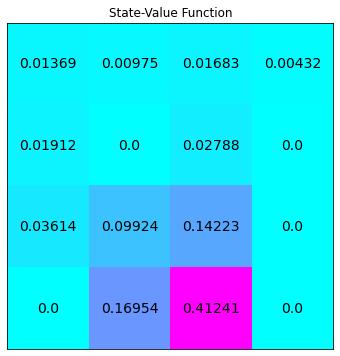

In [15]:
rand_agent = MyRandomAgent(env)
V= policy_MC_evaluation(env, rand_agent)
plot_values_lake(V)

In [16]:
V.sum()

0.9511432682037739

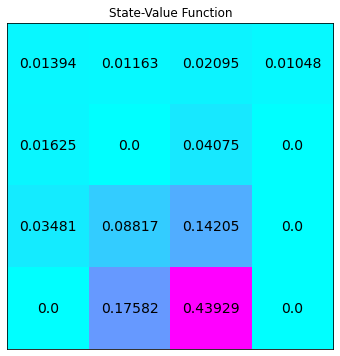

In [17]:
# In reality, here we know the model, we use it to control our results
rand_agent = MyRandomAgent(env)
V = policy_evaluation(env, rand_agent.policy) #see II) dynamic-programming
plot_values_lake(V)

In [18]:
V.sum()

0.9941411498416601

In the same way, we estimate the Q function. 

For Q evaluation
\begin{aligned}
Q(A_t, S_t) &\leftarrow Q(A_t, S_t) + \frac{1}{N_{\text{total}}(A_t, S_t)}(G_t - N_{\text{trajectory}}(A_t, S_t)Q(A_t, S_t))\\
\end{aligned}

And we train an agent, improving its policy by acting greddy.
$\forall s$ $\pi'(.|s) = \arg\max_a Q_\pi(s,a)$.

## Simplest exploration
Without knowing the model, we improve the policy by interacting with the environment. We start with an arbitrary policy, a major problem is caused by a local maximum due to insufficient exploration. To avoid it, we force the agent to act sometimes in a random way (control by an epsilon).

In [19]:
def get_epsilon_greedy_policy(Q_s, epsilon, nA):
    policy_s = np.ones(nA) * epsilon / nA
    best_a = np.argmax(Q_s)
    policy_s[best_a] = 1 - epsilon + (epsilon / nA)
    return policy_s

In [20]:
class MyMCAgent(Agent):
    def __init__(self, env, gamma = .99, epsilon = .1):
        super().__init__(env, gamma, epsilon)
        self.q = np.ones([self.env.observation_space.n, self.env.action_space.n])
        self.count_state_actions = np.zeros((self.env.observation_space.n, self.env.action_space.n))
        self.count_state_actions_by_update = np.zeros((self.env.observation_space.n, self.env.action_space.n))
        self.episode = []
    def train(self, current_state, action, reward, next_state, done):
        self.episode.append(np.array([current_state, action, reward])) # collect trajectories
        self.count_state_actions[current_state, action] += 1
        self.count_state_actions_by_update[current_state, action] += 1
        if done is True: # we train the agent at every end of episode
            episode = np.asarray(self.episode)
            discount_empirical_return = discount_cumsum(episode[:,2], self.gamma)
            for state in range(len(self.count_state_actions)): # evaluate Q
                for action, count in enumerate(self.count_state_actions[state]):
                    if count > 0 : # evaluate Q
                        self.q[state,action] += (discount_empirical_return[(episode[:,0] == state) & (episode[:,1] == action)].sum() - self.count_state_actions_by_update[state, action] * self.q[state,action]) / count
            self.count_state_actions_by_update = np.zeros((self.env.observation_space.n, self.env.action_space.n))
            self.episode = []
            for state in range(env.observation_space.n): # update policy
                self.policy[state] = get_epsilon_greedy_policy(self.q[state], self.epsilon, env.action_space.n)

episode: 0 - cum reward 0.0
episode: 1 - cum reward 0.0
episode: 2 - cum reward 0.0
episode: 3 - cum reward 0.0
episode: 4 - cum reward 0.0
episode: 5 - cum reward 0.0
episode: 6 - cum reward 0.0
episode: 7 - cum reward 0.0
episode: 8 - cum reward 0.0
episode: 9 - cum reward 0.0
episode: 10 - cum reward 0.0
episode: 11 - cum reward 0.0
episode: 12 - cum reward 0.0
episode: 13 - cum reward 0.0
episode: 14 - cum reward 0.0
episode: 15 - cum reward 0.0
episode: 16 - cum reward 0.0
episode: 17 - cum reward 0.0
episode: 18 - cum reward 0.0
episode: 19 - cum reward 0.0
episode: 20 - cum reward 0.0
episode: 21 - cum reward 0.0
episode: 22 - cum reward 0.0
episode: 23 - cum reward 0.0
episode: 24 - cum reward 0.0
episode: 25 - cum reward 0.0
episode: 26 - cum reward 0.0
episode: 27 - cum reward 0.0
episode: 28 - cum reward 0.0
episode: 29 - cum reward 0.0
episode: 30 - cum reward 0.0
episode: 31 - cum reward 0.0
episode: 32 - cum reward 0.0
episode: 33 - cum reward 0.0
episode: 34 - cum reward

episode: 309 - cum reward 0.0
episode: 310 - cum reward 0.0
episode: 311 - cum reward 0.0
episode: 312 - cum reward 0.0
episode: 313 - cum reward 0.0
episode: 314 - cum reward 0.0
episode: 315 - cum reward 0.0
episode: 316 - cum reward 0.0
episode: 317 - cum reward 0.0
episode: 318 - cum reward 0.0
episode: 319 - cum reward 0.0
episode: 320 - cum reward 0.0
episode: 321 - cum reward 0.0
episode: 322 - cum reward 0.0
episode: 323 - cum reward 0.0
episode: 324 - cum reward 0.0
episode: 325 - cum reward 0.0
episode: 326 - cum reward 0.0
episode: 327 - cum reward 0.0
episode: 328 - cum reward 0.0
episode: 329 - cum reward 0.0
episode: 330 - cum reward 0.0
episode: 331 - cum reward 0.0
episode: 332 - cum reward 0.0
episode: 333 - cum reward 0.0
episode: 334 - cum reward 0.0
episode: 335 - cum reward 0.0
episode: 336 - cum reward 0.0
episode: 337 - cum reward 0.0
episode: 338 - cum reward 0.0
episode: 339 - cum reward 0.0
episode: 340 - cum reward 0.0
episode: 341 - cum reward 0.0
episode: 3

episode: 634 - cum reward 0.0
episode: 635 - cum reward 0.0
episode: 636 - cum reward 0.0
episode: 637 - cum reward 0.0
episode: 638 - cum reward 0.0
episode: 639 - cum reward 0.0
episode: 640 - cum reward 0.0
episode: 641 - cum reward 0.0
episode: 642 - cum reward 0.0
episode: 643 - cum reward 0.0
episode: 644 - cum reward 0.0
episode: 645 - cum reward 0.0
episode: 646 - cum reward 0.0
episode: 647 - cum reward 0.0
episode: 648 - cum reward 0.0
episode: 649 - cum reward 0.0
episode: 650 - cum reward 0.0
episode: 651 - cum reward 0.0
episode: 652 - cum reward 0.0
episode: 653 - cum reward 0.0
episode: 654 - cum reward 0.0
episode: 655 - cum reward 0.0
episode: 656 - cum reward 0.0
episode: 657 - cum reward 0.0
episode: 658 - cum reward 0.0
episode: 659 - cum reward 0.0
episode: 660 - cum reward 0.0
episode: 661 - cum reward 0.0
episode: 662 - cum reward 0.0
episode: 663 - cum reward 0.0
episode: 664 - cum reward 0.0
episode: 665 - cum reward 0.0
episode: 666 - cum reward 0.0
episode: 6

episode: 990 - cum reward 0.0
episode: 991 - cum reward 0.0
episode: 992 - cum reward 0.0
episode: 993 - cum reward 0.0
episode: 994 - cum reward 0.0
episode: 995 - cum reward 0.0
episode: 996 - cum reward 0.0
episode: 997 - cum reward 0.0
episode: 998 - cum reward 0.0
episode: 999 - cum reward 0.0
episode: 1000 - cum reward 0.0
episode: 1001 - cum reward 0.0
episode: 1002 - cum reward 0.0
episode: 1003 - cum reward 0.0
episode: 1004 - cum reward 0.0
episode: 1005 - cum reward 0.0
episode: 1006 - cum reward 0.0
episode: 1007 - cum reward 0.0
episode: 1008 - cum reward 0.0
episode: 1009 - cum reward 0.0
episode: 1010 - cum reward 0.0
episode: 1011 - cum reward 0.0
episode: 1012 - cum reward 0.0
episode: 1013 - cum reward 0.0
episode: 1014 - cum reward 0.0
episode: 1015 - cum reward 0.0
episode: 1016 - cum reward 0.0
episode: 1017 - cum reward 0.0
episode: 1018 - cum reward 0.0
episode: 1019 - cum reward 0.0
episode: 1020 - cum reward 0.0
episode: 1021 - cum reward 0.0
episode: 1022 - cu

episode: 1432 - cum reward 0.0
episode: 1433 - cum reward 0.0
episode: 1434 - cum reward 0.0
episode: 1435 - cum reward 0.0
episode: 1436 - cum reward 0.0
episode: 1437 - cum reward 0.0
episode: 1438 - cum reward 0.0
episode: 1439 - cum reward 0.0
episode: 1440 - cum reward 0.0
episode: 1441 - cum reward 0.0
episode: 1442 - cum reward 0.0
episode: 1443 - cum reward 0.0
episode: 1444 - cum reward 0.0
episode: 1445 - cum reward 0.0
episode: 1446 - cum reward 0.0
episode: 1447 - cum reward 0.0
episode: 1448 - cum reward 0.0
episode: 1449 - cum reward 0.0
episode: 1450 - cum reward 0.0
episode: 1451 - cum reward 0.0
episode: 1452 - cum reward 1.0
episode: 1453 - cum reward 0.0
episode: 1454 - cum reward 0.0
episode: 1455 - cum reward 0.0
episode: 1456 - cum reward 0.0
episode: 1457 - cum reward 0.0
episode: 1458 - cum reward 0.0
episode: 1459 - cum reward 0.0
episode: 1460 - cum reward 0.0
episode: 1461 - cum reward 0.0
episode: 1462 - cum reward 0.0
episode: 1463 - cum reward 0.0
episode:

episode: 1851 - cum reward 0.0
episode: 1852 - cum reward 0.0
episode: 1853 - cum reward 0.0
episode: 1854 - cum reward 0.0
episode: 1855 - cum reward 0.0
episode: 1856 - cum reward 0.0
episode: 1857 - cum reward 0.0
episode: 1858 - cum reward 0.0
episode: 1859 - cum reward 0.0
episode: 1860 - cum reward 0.0
episode: 1861 - cum reward 1.0
episode: 1862 - cum reward 0.0
episode: 1863 - cum reward 0.0
episode: 1864 - cum reward 0.0
episode: 1865 - cum reward 0.0
episode: 1866 - cum reward 0.0
episode: 1867 - cum reward 0.0
episode: 1868 - cum reward 0.0
episode: 1869 - cum reward 0.0
episode: 1870 - cum reward 0.0
episode: 1871 - cum reward 0.0
episode: 1872 - cum reward 0.0
episode: 1873 - cum reward 0.0
episode: 1874 - cum reward 0.0
episode: 1875 - cum reward 0.0
episode: 1876 - cum reward 0.0
episode: 1877 - cum reward 0.0
episode: 1878 - cum reward 0.0
episode: 1879 - cum reward 0.0
episode: 1880 - cum reward 0.0
episode: 1881 - cum reward 0.0
episode: 1882 - cum reward 0.0
episode:

episode: 2295 - cum reward 0.0
episode: 2296 - cum reward 1.0
episode: 2297 - cum reward 0.0
episode: 2298 - cum reward 0.0
episode: 2299 - cum reward 0.0
episode: 2300 - cum reward 0.0
episode: 2301 - cum reward 0.0
episode: 2302 - cum reward 0.0
episode: 2303 - cum reward 0.0
episode: 2304 - cum reward 0.0
episode: 2305 - cum reward 0.0
episode: 2306 - cum reward 0.0
episode: 2307 - cum reward 1.0
episode: 2308 - cum reward 0.0
episode: 2309 - cum reward 0.0
episode: 2310 - cum reward 0.0
episode: 2311 - cum reward 0.0
episode: 2312 - cum reward 0.0
episode: 2313 - cum reward 0.0
episode: 2314 - cum reward 0.0
episode: 2315 - cum reward 0.0
episode: 2316 - cum reward 0.0
episode: 2317 - cum reward 0.0
episode: 2318 - cum reward 0.0
episode: 2319 - cum reward 0.0
episode: 2320 - cum reward 1.0
episode: 2321 - cum reward 0.0
episode: 2322 - cum reward 0.0
episode: 2323 - cum reward 0.0
episode: 2324 - cum reward 0.0
episode: 2325 - cum reward 0.0
episode: 2326 - cum reward 1.0
episode:

episode: 2655 - cum reward 0.0
episode: 2656 - cum reward 0.0
episode: 2657 - cum reward 0.0
episode: 2658 - cum reward 0.0
episode: 2659 - cum reward 0.0
episode: 2660 - cum reward 0.0
episode: 2661 - cum reward 0.0
episode: 2662 - cum reward 0.0
episode: 2663 - cum reward 0.0
episode: 2664 - cum reward 0.0
episode: 2665 - cum reward 0.0
episode: 2666 - cum reward 0.0
episode: 2667 - cum reward 0.0
episode: 2668 - cum reward 0.0
episode: 2669 - cum reward 0.0
episode: 2670 - cum reward 0.0
episode: 2671 - cum reward 0.0
episode: 2672 - cum reward 0.0
episode: 2673 - cum reward 0.0
episode: 2674 - cum reward 0.0
episode: 2675 - cum reward 0.0
episode: 2676 - cum reward 0.0
episode: 2677 - cum reward 0.0
episode: 2678 - cum reward 0.0
episode: 2679 - cum reward 0.0
episode: 2680 - cum reward 0.0
episode: 2681 - cum reward 1.0
episode: 2682 - cum reward 0.0
episode: 2683 - cum reward 0.0
episode: 2684 - cum reward 0.0
episode: 2685 - cum reward 0.0
episode: 2686 - cum reward 0.0
episode:

episode: 3009 - cum reward 0.0
episode: 3010 - cum reward 0.0
episode: 3011 - cum reward 0.0
episode: 3012 - cum reward 0.0
episode: 3013 - cum reward 0.0
episode: 3014 - cum reward 1.0
episode: 3015 - cum reward 0.0
episode: 3016 - cum reward 0.0
episode: 3017 - cum reward 0.0
episode: 3018 - cum reward 0.0
episode: 3019 - cum reward 0.0
episode: 3020 - cum reward 0.0
episode: 3021 - cum reward 0.0
episode: 3022 - cum reward 0.0
episode: 3023 - cum reward 0.0
episode: 3024 - cum reward 0.0
episode: 3025 - cum reward 1.0
episode: 3026 - cum reward 0.0
episode: 3027 - cum reward 0.0
episode: 3028 - cum reward 0.0
episode: 3029 - cum reward 0.0
episode: 3030 - cum reward 0.0
episode: 3031 - cum reward 0.0
episode: 3032 - cum reward 1.0
episode: 3033 - cum reward 0.0
episode: 3034 - cum reward 1.0
episode: 3035 - cum reward 0.0
episode: 3036 - cum reward 0.0
episode: 3037 - cum reward 0.0
episode: 3038 - cum reward 0.0
episode: 3039 - cum reward 0.0
episode: 3040 - cum reward 0.0
episode:

episode: 3355 - cum reward 0.0
episode: 3356 - cum reward 0.0
episode: 3357 - cum reward 0.0
episode: 3358 - cum reward 1.0
episode: 3359 - cum reward 0.0
episode: 3360 - cum reward 1.0
episode: 3361 - cum reward 0.0
episode: 3362 - cum reward 0.0
episode: 3363 - cum reward 0.0
episode: 3364 - cum reward 0.0
episode: 3365 - cum reward 0.0
episode: 3366 - cum reward 0.0
episode: 3367 - cum reward 0.0
episode: 3368 - cum reward 0.0
episode: 3369 - cum reward 0.0
episode: 3370 - cum reward 1.0
episode: 3371 - cum reward 0.0
episode: 3372 - cum reward 0.0
episode: 3373 - cum reward 0.0
episode: 3374 - cum reward 1.0
episode: 3375 - cum reward 0.0
episode: 3376 - cum reward 0.0
episode: 3377 - cum reward 0.0
episode: 3378 - cum reward 0.0
episode: 3379 - cum reward 0.0
episode: 3380 - cum reward 0.0
episode: 3381 - cum reward 0.0
episode: 3382 - cum reward 0.0
episode: 3383 - cum reward 0.0
episode: 3384 - cum reward 1.0
episode: 3385 - cum reward 0.0
episode: 3386 - cum reward 0.0
episode:

episode: 3685 - cum reward 0.0
episode: 3686 - cum reward 0.0
episode: 3687 - cum reward 0.0
episode: 3688 - cum reward 0.0
episode: 3689 - cum reward 0.0
episode: 3690 - cum reward 0.0
episode: 3691 - cum reward 1.0
episode: 3692 - cum reward 0.0
episode: 3693 - cum reward 0.0
episode: 3694 - cum reward 0.0
episode: 3695 - cum reward 0.0
episode: 3696 - cum reward 0.0
episode: 3697 - cum reward 0.0
episode: 3698 - cum reward 0.0
episode: 3699 - cum reward 1.0
episode: 3700 - cum reward 0.0
episode: 3701 - cum reward 0.0
episode: 3702 - cum reward 0.0
episode: 3703 - cum reward 0.0
episode: 3704 - cum reward 0.0
episode: 3705 - cum reward 1.0
episode: 3706 - cum reward 1.0
episode: 3707 - cum reward 0.0
episode: 3708 - cum reward 0.0
episode: 3709 - cum reward 0.0
episode: 3710 - cum reward 1.0
episode: 3711 - cum reward 0.0
episode: 3712 - cum reward 0.0
episode: 3713 - cum reward 0.0
episode: 3714 - cum reward 0.0
episode: 3715 - cum reward 0.0
episode: 3716 - cum reward 0.0
episode:

episode: 4011 - cum reward 0.0
episode: 4012 - cum reward 0.0
episode: 4013 - cum reward 0.0
episode: 4014 - cum reward 0.0
episode: 4015 - cum reward 0.0
episode: 4016 - cum reward 0.0
episode: 4017 - cum reward 0.0
episode: 4018 - cum reward 0.0
episode: 4019 - cum reward 1.0
episode: 4020 - cum reward 0.0
episode: 4021 - cum reward 0.0
episode: 4022 - cum reward 0.0
episode: 4023 - cum reward 0.0
episode: 4024 - cum reward 0.0
episode: 4025 - cum reward 0.0
episode: 4026 - cum reward 0.0
episode: 4027 - cum reward 0.0
episode: 4028 - cum reward 0.0
episode: 4029 - cum reward 0.0
episode: 4030 - cum reward 0.0
episode: 4031 - cum reward 0.0
episode: 4032 - cum reward 0.0
episode: 4033 - cum reward 1.0
episode: 4034 - cum reward 0.0
episode: 4035 - cum reward 0.0
episode: 4036 - cum reward 0.0
episode: 4037 - cum reward 0.0
episode: 4038 - cum reward 0.0
episode: 4039 - cum reward 0.0
episode: 4040 - cum reward 0.0
episode: 4041 - cum reward 0.0
episode: 4042 - cum reward 0.0
episode:

episode: 4374 - cum reward 0.0
episode: 4375 - cum reward 0.0
episode: 4376 - cum reward 0.0
episode: 4377 - cum reward 0.0
episode: 4378 - cum reward 0.0
episode: 4379 - cum reward 1.0
episode: 4380 - cum reward 0.0
episode: 4381 - cum reward 0.0
episode: 4382 - cum reward 0.0
episode: 4383 - cum reward 0.0
episode: 4384 - cum reward 0.0
episode: 4385 - cum reward 0.0
episode: 4386 - cum reward 0.0
episode: 4387 - cum reward 1.0
episode: 4388 - cum reward 0.0
episode: 4389 - cum reward 0.0
episode: 4390 - cum reward 0.0
episode: 4391 - cum reward 0.0
episode: 4392 - cum reward 1.0
episode: 4393 - cum reward 0.0
episode: 4394 - cum reward 0.0
episode: 4395 - cum reward 0.0
episode: 4396 - cum reward 0.0
episode: 4397 - cum reward 0.0
episode: 4398 - cum reward 0.0
episode: 4399 - cum reward 0.0
episode: 4400 - cum reward 0.0
episode: 4401 - cum reward 0.0
episode: 4402 - cum reward 1.0
episode: 4403 - cum reward 0.0
episode: 4404 - cum reward 0.0
episode: 4405 - cum reward 0.0
episode:

episode: 4706 - cum reward 0.0
episode: 4707 - cum reward 1.0
episode: 4708 - cum reward 0.0
episode: 4709 - cum reward 0.0
episode: 4710 - cum reward 0.0
episode: 4711 - cum reward 0.0
episode: 4712 - cum reward 0.0
episode: 4713 - cum reward 0.0
episode: 4714 - cum reward 0.0
episode: 4715 - cum reward 1.0
episode: 4716 - cum reward 0.0
episode: 4717 - cum reward 1.0
episode: 4718 - cum reward 0.0
episode: 4719 - cum reward 0.0
episode: 4720 - cum reward 0.0
episode: 4721 - cum reward 0.0
episode: 4722 - cum reward 1.0
episode: 4723 - cum reward 0.0
episode: 4724 - cum reward 0.0
episode: 4725 - cum reward 0.0
episode: 4726 - cum reward 0.0
episode: 4727 - cum reward 0.0
episode: 4728 - cum reward 0.0
episode: 4729 - cum reward 0.0
episode: 4730 - cum reward 0.0
episode: 4731 - cum reward 0.0
episode: 4732 - cum reward 0.0
episode: 4733 - cum reward 0.0
episode: 4734 - cum reward 0.0
episode: 4735 - cum reward 0.0
episode: 4736 - cum reward 0.0
episode: 4737 - cum reward 1.0
episode:

Text(0.5, 1.0, 'cumulative reward per episode - mc_agent')

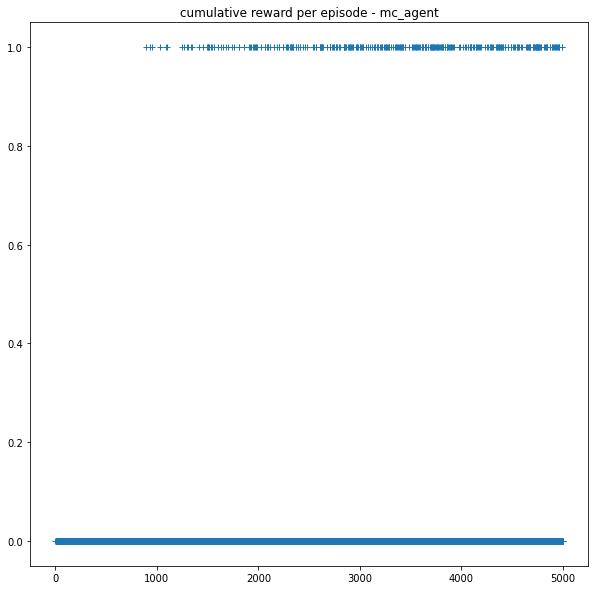

In [21]:
mc_agent = MyMCAgent(env)
rewards = run_experiment_episode_train(env, mc_agent, 5000)
fig,ax = plt.subplots(figsize=(10,10))
ax.plot(rewards,'+')
ax.set_title('cumulative reward per episode - mc_agent')

In [22]:
mc_agent.policy

array([[0.025, 0.025, 0.925, 0.025],
       [0.025, 0.025, 0.025, 0.925],
       [0.925, 0.025, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.025, 0.025, 0.925, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.025, 0.025, 0.025, 0.925],
       [0.025, 0.925, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.025, 0.025, 0.925, 0.025],
       [0.025, 0.025, 0.925, 0.025],
       [0.925, 0.025, 0.025, 0.025]])

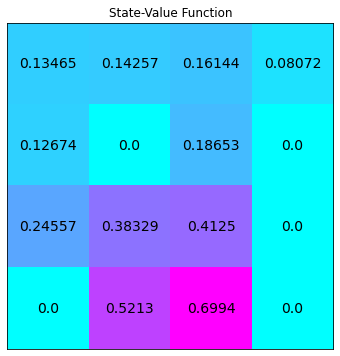

In [23]:
V = policy_evaluation(env, mc_agent.policy)
plot_values_lake(V)

In [24]:
V.sum()

3.094720267562016

# Temporal-Difference-Learning (Monte-Carlo bootstrap) 

Using monte-carlo, we update $V(S_t)$ in that way

\begin{aligned}
V(S_t) &\leftarrow V(S_t) + \alpha (G_t - V(S_t)) \\
\end{aligned}
Using bellman equation $\mathbb{E}[G_t|S_t=s] = \mathbb{E}[R_{t+1} + \gamma V(S_{t+1})|S_t=s]$, That pushes new estimators/update

TD target $= R_{t+1} + \gamma V(S_{t+1}$)

TD error $=$ target $- V(S_t)$

update:  

\begin{aligned}
V(S_t) &\leftarrow V(S_t) + \alpha (R_{t+1} + \gamma V(S_{t+1}) - V(S_t))
\end{aligned}

In [25]:
#TODO: complete policy td evaluation step
def policy_td_evaluation(env, agent, gamma=1, nb_episode=5000, alpha = .01):
    V = np.zeros(env.observation_space.n)
    for i in range(nb_episode):
        count_states = np.zeros(env.observation_space.n)
        state = env.reset()
        done = False
        while done is False:
            action = agent.act(state)
            current_state = state
            state, reward, done, info = env.step(action)
            target = reward + gamma * V[state]
            td_error = target - V[current_state]
            count_states[current_state] += 1
            V[current_state] += None #complete here
    return V

In [26]:
#Done: complete policy td evaluation step
def policy_td_evaluation(env, agent, gamma=1, nb_episode=5000, alpha = .01):
    V = np.zeros(env.observation_space.n)
    for i in range(nb_episode):
        count_states = np.zeros(env.observation_space.n)
        state = env.reset()
        done = False
        while done is False:
            action = agent.act(state)
            current_state = state
            state, reward, done, info = env.step(action)
            target = reward + gamma * V[state]
            td_error = target - V[current_state]
            count_states[current_state] += 1
            V[current_state] += td_error * alpha
    return V

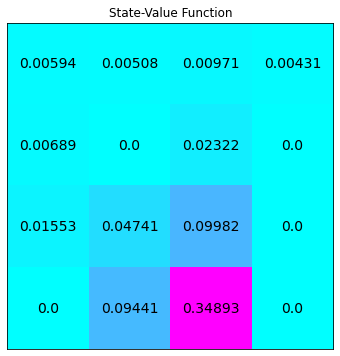

In [27]:
rand_agent = MyRandomAgent(env)
V = policy_td_evaluation(env, rand_agent)
plot_values_lake(V)

### SARSA

Same principle for q function update using Temporal difference$Q(S_t,A_t) \leftarrow Q(S_t,A_t)+ \alpha(R_{t+1}+\gamma Q(S_{t+1},A_{t+1})−Q(S_t,A_t))$.

In [28]:
class MySarsaAgent(Agent):
    def __init__(self, env, gamma = .99, epsilon = .1, alpha = .01):
        super().__init__(env, gamma, epsilon)
        self.alpha = alpha
        self.q = np.ones([self.env.observation_space.n, self.env.action_space.n]) / self.env.action_space.n
        self.sarsa = [None, None, None, None, None] #[s,a,r,s,a]
        self.tmp_reward = None
    def qsa_update(self, done):
        if done:
            target = self.sarsa[2]
        else:
            target = self.sarsa[2] + self.gamma * self.q[self.sarsa[-2], self.sarsa[-1]] 
        td_error = target - self.q[self.sarsa[0], self.sarsa[1]]
        self.q[self.sarsa[0], self.sarsa[1]]  += self.alpha * td_error
        
    def train(self, current_state, action, reward, next_state, done):
        self.sarsa[0] = self.sarsa[-2]
        self.sarsa[1] = self.sarsa[-1]
        self.sarsa[2] = self.tmp_reward
        self.sarsa[3] = current_state
        self.sarsa[4] = action
        self.tmp_reward = reward
        if self.sarsa[0] is None:
            pass
        else:
            self.qsa_update(done)
        for state in range(env.observation_space.n):
            self.policy[state] = get_epsilon_greedy_policy(self.q[state], self.epsilon, env.action_space.n)

episode: 0 - cum reward 0.0
episode: 1 - cum reward 0.0
episode: 2 - cum reward 0.0
episode: 3 - cum reward 0.0
episode: 4 - cum reward 0.0
episode: 5 - cum reward 0.0
episode: 6 - cum reward 0.0
episode: 7 - cum reward 0.0
episode: 8 - cum reward 0.0
episode: 9 - cum reward 0.0
episode: 10 - cum reward 0.0
episode: 11 - cum reward 0.0
episode: 12 - cum reward 0.0
episode: 13 - cum reward 0.0
episode: 14 - cum reward 0.0
episode: 15 - cum reward 0.0
episode: 16 - cum reward 0.0
episode: 17 - cum reward 0.0
episode: 18 - cum reward 0.0
episode: 19 - cum reward 0.0
episode: 20 - cum reward 0.0
episode: 21 - cum reward 0.0
episode: 22 - cum reward 0.0
episode: 23 - cum reward 0.0
episode: 24 - cum reward 0.0
episode: 25 - cum reward 0.0
episode: 26 - cum reward 0.0
episode: 27 - cum reward 0.0
episode: 28 - cum reward 0.0
episode: 29 - cum reward 0.0
episode: 30 - cum reward 0.0
episode: 31 - cum reward 0.0
episode: 32 - cum reward 0.0
episode: 33 - cum reward 0.0
episode: 34 - cum reward

episode: 350 - cum reward 0.0
episode: 351 - cum reward 0.0
episode: 352 - cum reward 0.0
episode: 353 - cum reward 0.0
episode: 354 - cum reward 0.0
episode: 355 - cum reward 0.0
episode: 356 - cum reward 0.0
episode: 357 - cum reward 0.0
episode: 358 - cum reward 0.0
episode: 359 - cum reward 0.0
episode: 360 - cum reward 0.0
episode: 361 - cum reward 0.0
episode: 362 - cum reward 0.0
episode: 363 - cum reward 0.0
episode: 364 - cum reward 0.0
episode: 365 - cum reward 0.0
episode: 366 - cum reward 0.0
episode: 367 - cum reward 0.0
episode: 368 - cum reward 0.0
episode: 369 - cum reward 0.0
episode: 370 - cum reward 0.0
episode: 371 - cum reward 0.0
episode: 372 - cum reward 0.0
episode: 373 - cum reward 0.0
episode: 374 - cum reward 0.0
episode: 375 - cum reward 0.0
episode: 376 - cum reward 0.0
episode: 377 - cum reward 0.0
episode: 378 - cum reward 0.0
episode: 379 - cum reward 0.0
episode: 380 - cum reward 0.0
episode: 381 - cum reward 0.0
episode: 382 - cum reward 0.0
episode: 3

episode: 638 - cum reward 0.0
episode: 639 - cum reward 0.0
episode: 640 - cum reward 0.0
episode: 641 - cum reward 0.0
episode: 642 - cum reward 0.0
episode: 643 - cum reward 0.0
episode: 644 - cum reward 0.0
episode: 645 - cum reward 0.0
episode: 646 - cum reward 0.0
episode: 647 - cum reward 0.0
episode: 648 - cum reward 0.0
episode: 649 - cum reward 0.0
episode: 650 - cum reward 0.0
episode: 651 - cum reward 0.0
episode: 652 - cum reward 0.0
episode: 653 - cum reward 0.0
episode: 654 - cum reward 0.0
episode: 655 - cum reward 0.0
episode: 656 - cum reward 0.0
episode: 657 - cum reward 0.0
episode: 658 - cum reward 0.0
episode: 659 - cum reward 0.0
episode: 660 - cum reward 0.0
episode: 661 - cum reward 0.0
episode: 662 - cum reward 1.0
episode: 663 - cum reward 0.0
episode: 664 - cum reward 0.0
episode: 665 - cum reward 0.0
episode: 666 - cum reward 0.0
episode: 667 - cum reward 0.0
episode: 668 - cum reward 0.0
episode: 669 - cum reward 0.0
episode: 670 - cum reward 0.0
episode: 6

episode: 952 - cum reward 0.0
episode: 953 - cum reward 0.0
episode: 954 - cum reward 0.0
episode: 955 - cum reward 0.0
episode: 956 - cum reward 0.0
episode: 957 - cum reward 0.0
episode: 958 - cum reward 0.0
episode: 959 - cum reward 0.0
episode: 960 - cum reward 0.0
episode: 961 - cum reward 1.0
episode: 962 - cum reward 0.0
episode: 963 - cum reward 0.0
episode: 964 - cum reward 0.0
episode: 965 - cum reward 0.0
episode: 966 - cum reward 0.0
episode: 967 - cum reward 0.0
episode: 968 - cum reward 0.0
episode: 969 - cum reward 0.0
episode: 970 - cum reward 0.0
episode: 971 - cum reward 0.0
episode: 972 - cum reward 0.0
episode: 973 - cum reward 0.0
episode: 974 - cum reward 1.0
episode: 975 - cum reward 0.0
episode: 976 - cum reward 0.0
episode: 977 - cum reward 0.0
episode: 978 - cum reward 0.0
episode: 979 - cum reward 0.0
episode: 980 - cum reward 0.0
episode: 981 - cum reward 0.0
episode: 982 - cum reward 0.0
episode: 983 - cum reward 0.0
episode: 984 - cum reward 0.0
episode: 9

episode: 1271 - cum reward 0.0
episode: 1272 - cum reward 0.0
episode: 1273 - cum reward 0.0
episode: 1274 - cum reward 0.0
episode: 1275 - cum reward 0.0
episode: 1276 - cum reward 0.0
episode: 1277 - cum reward 0.0
episode: 1278 - cum reward 0.0
episode: 1279 - cum reward 0.0
episode: 1280 - cum reward 0.0
episode: 1281 - cum reward 0.0
episode: 1282 - cum reward 0.0
episode: 1283 - cum reward 0.0
episode: 1284 - cum reward 0.0
episode: 1285 - cum reward 0.0
episode: 1286 - cum reward 0.0
episode: 1287 - cum reward 0.0
episode: 1288 - cum reward 0.0
episode: 1289 - cum reward 0.0
episode: 1290 - cum reward 0.0
episode: 1291 - cum reward 0.0
episode: 1292 - cum reward 0.0
episode: 1293 - cum reward 0.0
episode: 1294 - cum reward 0.0
episode: 1295 - cum reward 0.0
episode: 1296 - cum reward 0.0
episode: 1297 - cum reward 0.0
episode: 1298 - cum reward 0.0
episode: 1299 - cum reward 0.0
episode: 1300 - cum reward 0.0
episode: 1301 - cum reward 0.0
episode: 1302 - cum reward 0.0
episode:

episode: 1579 - cum reward 0.0
episode: 1580 - cum reward 0.0
episode: 1581 - cum reward 0.0
episode: 1582 - cum reward 0.0
episode: 1583 - cum reward 0.0
episode: 1584 - cum reward 0.0
episode: 1585 - cum reward 1.0
episode: 1586 - cum reward 0.0
episode: 1587 - cum reward 0.0
episode: 1588 - cum reward 0.0
episode: 1589 - cum reward 0.0
episode: 1590 - cum reward 0.0
episode: 1591 - cum reward 0.0
episode: 1592 - cum reward 0.0
episode: 1593 - cum reward 0.0
episode: 1594 - cum reward 0.0
episode: 1595 - cum reward 0.0
episode: 1596 - cum reward 0.0
episode: 1597 - cum reward 0.0
episode: 1598 - cum reward 0.0
episode: 1599 - cum reward 0.0
episode: 1600 - cum reward 0.0
episode: 1601 - cum reward 0.0
episode: 1602 - cum reward 0.0
episode: 1603 - cum reward 0.0
episode: 1604 - cum reward 0.0
episode: 1605 - cum reward 0.0
episode: 1606 - cum reward 0.0
episode: 1607 - cum reward 0.0
episode: 1608 - cum reward 0.0
episode: 1609 - cum reward 0.0
episode: 1610 - cum reward 0.0
episode:

episode: 1888 - cum reward 0.0
episode: 1889 - cum reward 0.0
episode: 1890 - cum reward 0.0
episode: 1891 - cum reward 0.0
episode: 1892 - cum reward 1.0
episode: 1893 - cum reward 0.0
episode: 1894 - cum reward 0.0
episode: 1895 - cum reward 0.0
episode: 1896 - cum reward 0.0
episode: 1897 - cum reward 0.0
episode: 1898 - cum reward 0.0
episode: 1899 - cum reward 0.0
episode: 1900 - cum reward 0.0
episode: 1901 - cum reward 1.0
episode: 1902 - cum reward 0.0
episode: 1903 - cum reward 0.0
episode: 1904 - cum reward 0.0
episode: 1905 - cum reward 0.0
episode: 1906 - cum reward 0.0
episode: 1907 - cum reward 0.0
episode: 1908 - cum reward 1.0
episode: 1909 - cum reward 0.0
episode: 1910 - cum reward 0.0
episode: 1911 - cum reward 0.0
episode: 1912 - cum reward 0.0
episode: 1913 - cum reward 0.0
episode: 1914 - cum reward 0.0
episode: 1915 - cum reward 0.0
episode: 1916 - cum reward 0.0
episode: 1917 - cum reward 0.0
episode: 1918 - cum reward 0.0
episode: 1919 - cum reward 0.0
episode:

episode: 2166 - cum reward 0.0
episode: 2167 - cum reward 0.0
episode: 2168 - cum reward 0.0
episode: 2169 - cum reward 0.0
episode: 2170 - cum reward 0.0
episode: 2171 - cum reward 0.0
episode: 2172 - cum reward 0.0
episode: 2173 - cum reward 0.0
episode: 2174 - cum reward 0.0
episode: 2175 - cum reward 0.0
episode: 2176 - cum reward 0.0
episode: 2177 - cum reward 0.0
episode: 2178 - cum reward 0.0
episode: 2179 - cum reward 0.0
episode: 2180 - cum reward 0.0
episode: 2181 - cum reward 0.0
episode: 2182 - cum reward 0.0
episode: 2183 - cum reward 0.0
episode: 2184 - cum reward 0.0
episode: 2185 - cum reward 0.0
episode: 2186 - cum reward 0.0
episode: 2187 - cum reward 0.0
episode: 2188 - cum reward 0.0
episode: 2189 - cum reward 0.0
episode: 2190 - cum reward 0.0
episode: 2191 - cum reward 0.0
episode: 2192 - cum reward 0.0
episode: 2193 - cum reward 0.0
episode: 2194 - cum reward 0.0
episode: 2195 - cum reward 0.0
episode: 2196 - cum reward 0.0
episode: 2197 - cum reward 0.0
episode:

episode: 2516 - cum reward 0.0
episode: 2517 - cum reward 0.0
episode: 2518 - cum reward 0.0
episode: 2519 - cum reward 0.0
episode: 2520 - cum reward 0.0
episode: 2521 - cum reward 0.0
episode: 2522 - cum reward 0.0
episode: 2523 - cum reward 0.0
episode: 2524 - cum reward 0.0
episode: 2525 - cum reward 0.0
episode: 2526 - cum reward 0.0
episode: 2527 - cum reward 0.0
episode: 2528 - cum reward 0.0
episode: 2529 - cum reward 0.0
episode: 2530 - cum reward 0.0
episode: 2531 - cum reward 0.0
episode: 2532 - cum reward 0.0
episode: 2533 - cum reward 0.0
episode: 2534 - cum reward 0.0
episode: 2535 - cum reward 0.0
episode: 2536 - cum reward 0.0
episode: 2537 - cum reward 1.0
episode: 2538 - cum reward 0.0
episode: 2539 - cum reward 0.0
episode: 2540 - cum reward 1.0
episode: 2541 - cum reward 0.0
episode: 2542 - cum reward 0.0
episode: 2543 - cum reward 0.0
episode: 2544 - cum reward 0.0
episode: 2545 - cum reward 0.0
episode: 2546 - cum reward 0.0
episode: 2547 - cum reward 0.0
episode:

episode: 2837 - cum reward 0.0
episode: 2838 - cum reward 0.0
episode: 2839 - cum reward 0.0
episode: 2840 - cum reward 0.0
episode: 2841 - cum reward 1.0
episode: 2842 - cum reward 0.0
episode: 2843 - cum reward 0.0
episode: 2844 - cum reward 0.0
episode: 2845 - cum reward 0.0
episode: 2846 - cum reward 0.0
episode: 2847 - cum reward 0.0
episode: 2848 - cum reward 0.0
episode: 2849 - cum reward 0.0
episode: 2850 - cum reward 0.0
episode: 2851 - cum reward 1.0
episode: 2852 - cum reward 0.0
episode: 2853 - cum reward 0.0
episode: 2854 - cum reward 1.0
episode: 2855 - cum reward 1.0
episode: 2856 - cum reward 0.0
episode: 2857 - cum reward 0.0
episode: 2858 - cum reward 0.0
episode: 2859 - cum reward 0.0
episode: 2860 - cum reward 0.0
episode: 2861 - cum reward 0.0
episode: 2862 - cum reward 0.0
episode: 2863 - cum reward 0.0
episode: 2864 - cum reward 0.0
episode: 2865 - cum reward 0.0
episode: 2866 - cum reward 0.0
episode: 2867 - cum reward 0.0
episode: 2868 - cum reward 0.0
episode:

episode: 3189 - cum reward 0.0
episode: 3190 - cum reward 1.0
episode: 3191 - cum reward 0.0
episode: 3192 - cum reward 0.0
episode: 3193 - cum reward 0.0
episode: 3194 - cum reward 0.0
episode: 3195 - cum reward 0.0
episode: 3196 - cum reward 0.0
episode: 3197 - cum reward 0.0
episode: 3198 - cum reward 0.0
episode: 3199 - cum reward 0.0
episode: 3200 - cum reward 0.0
episode: 3201 - cum reward 0.0
episode: 3202 - cum reward 0.0
episode: 3203 - cum reward 0.0
episode: 3204 - cum reward 0.0
episode: 3205 - cum reward 0.0
episode: 3206 - cum reward 0.0
episode: 3207 - cum reward 0.0
episode: 3208 - cum reward 0.0
episode: 3209 - cum reward 0.0
episode: 3210 - cum reward 0.0
episode: 3211 - cum reward 0.0
episode: 3212 - cum reward 0.0
episode: 3213 - cum reward 0.0
episode: 3214 - cum reward 0.0
episode: 3215 - cum reward 0.0
episode: 3216 - cum reward 0.0
episode: 3217 - cum reward 0.0
episode: 3218 - cum reward 0.0
episode: 3219 - cum reward 0.0
episode: 3220 - cum reward 0.0
episode:

episode: 3496 - cum reward 0.0
episode: 3497 - cum reward 0.0
episode: 3498 - cum reward 0.0
episode: 3499 - cum reward 0.0
episode: 3500 - cum reward 0.0
episode: 3501 - cum reward 0.0
episode: 3502 - cum reward 0.0
episode: 3503 - cum reward 1.0
episode: 3504 - cum reward 0.0
episode: 3505 - cum reward 0.0
episode: 3506 - cum reward 0.0
episode: 3507 - cum reward 0.0
episode: 3508 - cum reward 0.0
episode: 3509 - cum reward 0.0
episode: 3510 - cum reward 0.0
episode: 3511 - cum reward 0.0
episode: 3512 - cum reward 0.0
episode: 3513 - cum reward 0.0
episode: 3514 - cum reward 0.0
episode: 3515 - cum reward 0.0
episode: 3516 - cum reward 0.0
episode: 3517 - cum reward 0.0
episode: 3518 - cum reward 0.0
episode: 3519 - cum reward 0.0
episode: 3520 - cum reward 1.0
episode: 3521 - cum reward 0.0
episode: 3522 - cum reward 0.0
episode: 3523 - cum reward 1.0
episode: 3524 - cum reward 0.0
episode: 3525 - cum reward 1.0
episode: 3526 - cum reward 0.0
episode: 3527 - cum reward 0.0
episode:

episode: 3806 - cum reward 0.0
episode: 3807 - cum reward 0.0
episode: 3808 - cum reward 0.0
episode: 3809 - cum reward 0.0
episode: 3810 - cum reward 0.0
episode: 3811 - cum reward 0.0
episode: 3812 - cum reward 0.0
episode: 3813 - cum reward 0.0
episode: 3814 - cum reward 0.0
episode: 3815 - cum reward 0.0
episode: 3816 - cum reward 0.0
episode: 3817 - cum reward 0.0
episode: 3818 - cum reward 0.0
episode: 3819 - cum reward 0.0
episode: 3820 - cum reward 0.0
episode: 3821 - cum reward 0.0
episode: 3822 - cum reward 0.0
episode: 3823 - cum reward 1.0
episode: 3824 - cum reward 0.0
episode: 3825 - cum reward 0.0
episode: 3826 - cum reward 0.0
episode: 3827 - cum reward 0.0
episode: 3828 - cum reward 1.0
episode: 3829 - cum reward 1.0
episode: 3830 - cum reward 0.0
episode: 3831 - cum reward 0.0
episode: 3832 - cum reward 0.0
episode: 3833 - cum reward 0.0
episode: 3834 - cum reward 0.0
episode: 3835 - cum reward 0.0
episode: 3836 - cum reward 0.0
episode: 3837 - cum reward 0.0
episode:

episode: 4090 - cum reward 0.0
episode: 4091 - cum reward 0.0
episode: 4092 - cum reward 0.0
episode: 4093 - cum reward 0.0
episode: 4094 - cum reward 1.0
episode: 4095 - cum reward 0.0
episode: 4096 - cum reward 0.0
episode: 4097 - cum reward 0.0
episode: 4098 - cum reward 0.0
episode: 4099 - cum reward 0.0
episode: 4100 - cum reward 0.0
episode: 4101 - cum reward 0.0
episode: 4102 - cum reward 0.0
episode: 4103 - cum reward 0.0
episode: 4104 - cum reward 0.0
episode: 4105 - cum reward 0.0
episode: 4106 - cum reward 0.0
episode: 4107 - cum reward 0.0
episode: 4108 - cum reward 0.0
episode: 4109 - cum reward 0.0
episode: 4110 - cum reward 0.0
episode: 4111 - cum reward 1.0
episode: 4112 - cum reward 0.0
episode: 4113 - cum reward 0.0
episode: 4114 - cum reward 0.0
episode: 4115 - cum reward 0.0
episode: 4116 - cum reward 0.0
episode: 4117 - cum reward 1.0
episode: 4118 - cum reward 0.0
episode: 4119 - cum reward 0.0
episode: 4120 - cum reward 0.0
episode: 4121 - cum reward 0.0
episode:

episode: 4434 - cum reward 1.0
episode: 4435 - cum reward 0.0
episode: 4436 - cum reward 0.0
episode: 4437 - cum reward 0.0
episode: 4438 - cum reward 0.0
episode: 4439 - cum reward 0.0
episode: 4440 - cum reward 0.0
episode: 4441 - cum reward 0.0
episode: 4442 - cum reward 0.0
episode: 4443 - cum reward 0.0
episode: 4444 - cum reward 0.0
episode: 4445 - cum reward 0.0
episode: 4446 - cum reward 0.0
episode: 4447 - cum reward 0.0
episode: 4448 - cum reward 0.0
episode: 4449 - cum reward 0.0
episode: 4450 - cum reward 0.0
episode: 4451 - cum reward 0.0
episode: 4452 - cum reward 0.0
episode: 4453 - cum reward 0.0
episode: 4454 - cum reward 0.0
episode: 4455 - cum reward 0.0
episode: 4456 - cum reward 0.0
episode: 4457 - cum reward 1.0
episode: 4458 - cum reward 1.0
episode: 4459 - cum reward 1.0
episode: 4460 - cum reward 0.0
episode: 4461 - cum reward 0.0
episode: 4462 - cum reward 0.0
episode: 4463 - cum reward 0.0
episode: 4464 - cum reward 0.0
episode: 4465 - cum reward 0.0
episode:

episode: 4731 - cum reward 0.0
episode: 4732 - cum reward 0.0
episode: 4733 - cum reward 1.0
episode: 4734 - cum reward 0.0
episode: 4735 - cum reward 0.0
episode: 4736 - cum reward 0.0
episode: 4737 - cum reward 1.0
episode: 4738 - cum reward 0.0
episode: 4739 - cum reward 0.0
episode: 4740 - cum reward 0.0
episode: 4741 - cum reward 0.0
episode: 4742 - cum reward 1.0
episode: 4743 - cum reward 1.0
episode: 4744 - cum reward 0.0
episode: 4745 - cum reward 0.0
episode: 4746 - cum reward 1.0
episode: 4747 - cum reward 1.0
episode: 4748 - cum reward 0.0
episode: 4749 - cum reward 1.0
episode: 4750 - cum reward 0.0
episode: 4751 - cum reward 1.0
episode: 4752 - cum reward 0.0
episode: 4753 - cum reward 1.0
episode: 4754 - cum reward 0.0
episode: 4755 - cum reward 0.0
episode: 4756 - cum reward 0.0
episode: 4757 - cum reward 0.0
episode: 4758 - cum reward 0.0
episode: 4759 - cum reward 0.0
episode: 4760 - cum reward 1.0
episode: 4761 - cum reward 0.0
episode: 4762 - cum reward 0.0
episode:

Text(0.5, 1.0, 'cumulative reward per episode - sarsa_agent')

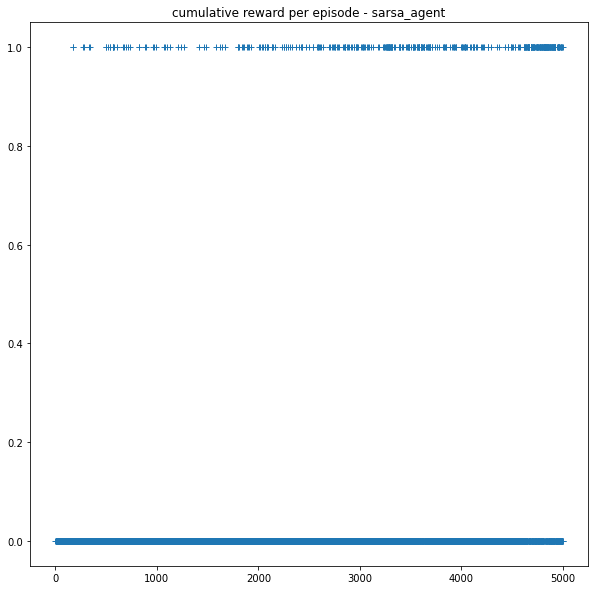

In [29]:
sarsa_agent = MySarsaAgent(env)
rewards = run_experiment_episode_train(env, sarsa_agent, 5000)
fig,ax = plt.subplots(figsize=(10,10))
ax.plot(rewards,'+')
ax.set_title('cumulative reward per episode - sarsa_agent')

In [30]:
sarsa_agent.policy

array([[0.925, 0.025, 0.025, 0.025],
       [0.025, 0.925, 0.025, 0.025],
       [0.025, 0.025, 0.025, 0.925],
       [0.025, 0.925, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.025, 0.925, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.025, 0.025, 0.025, 0.925],
       [0.025, 0.925, 0.025, 0.025],
       [0.025, 0.925, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.025, 0.025, 0.925, 0.025],
       [0.025, 0.925, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025]])

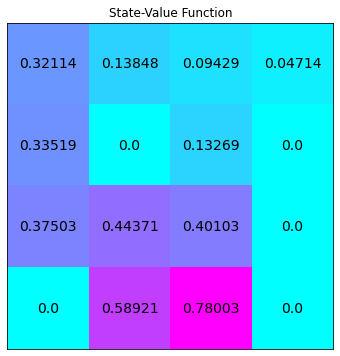

In [31]:
V = policy_evaluation(env, sarsa_agent.policy)
plot_values_lake(V)

In [32]:
V.sum()

3.6579466015720365

### Q-learning

Q learning is an offpolicy sarsa. Instead of update the Q function with the current policy action, it uses a greedy estimation of the policy action

SARAS $Q(S_t,A_t) \leftarrow Q(S_t,A_t)+ \alpha(R_{t+1}+\gamma Q(S_{t+1},A_{t+1})−Q(S_t,A_t))$

Q-learning $Q(S_t,A_t) \leftarrow Q(S_t,A_t)+ \alpha(R_{t+1}+\gamma \max_a Q(S_{t+1},a)−Q(S_t,A_t))$

In [33]:
#TODO: write Q learning update
class MyQAgent(Agent):
    def __init__(self, env, gamma = .99, epsilon = .1, alpha = .01):
        super().__init__(env, gamma, epsilon)
        self.alpha = alpha
        self.q = np.ones([self.env.observation_space.n, self.env.action_space.n]) / self.env.action_space.n
    def qsa_update(self, state, action, reward, next_state, done): 
        pass #complete here
    def train(self, current_state, action, reward, next_state, done):
        self.qsa_update(current_state, action, reward, next_state, done)
        for state in range(env.observation_space.n):
            self.policy[state] = get_epsilon_greedy_policy(self.q[state], self.epsilon, env.action_space.n)

In [34]:
#Done: write Q learning update
class MyQAgent(Agent):
    def __init__(self, env, gamma = .99, epsilon = .1, alpha = .01):
        super().__init__(env, gamma, epsilon)
        self.alpha = alpha
        self.q = np.ones([self.env.observation_space.n, self.env.action_space.n]) / self.env.action_space.n
    def qsa_update(self, state, action, reward, next_state, done): 
        if done is False:
            target = reward + self.gamma * np.max(self.q[next_state, :])
        else:
            target = reward
        td_error = target - self.q[state, action]
        self.q[state, action]  += self.alpha * td_error
    def train(self, current_state, action, reward, next_state, done):
        self.qsa_update(current_state, action, reward, next_state, done)
        for state in range(env.observation_space.n):
            self.policy[state] = get_epsilon_greedy_policy(self.q[state], self.epsilon, env.action_space.n)

episode: 0 - cum reward 0.0
episode: 1 - cum reward 0.0
episode: 2 - cum reward 0.0
episode: 3 - cum reward 0.0
episode: 4 - cum reward 0.0
episode: 5 - cum reward 0.0
episode: 6 - cum reward 0.0
episode: 7 - cum reward 0.0
episode: 8 - cum reward 0.0
episode: 9 - cum reward 0.0
episode: 10 - cum reward 0.0
episode: 11 - cum reward 0.0
episode: 12 - cum reward 0.0
episode: 13 - cum reward 0.0
episode: 14 - cum reward 1.0
episode: 15 - cum reward 0.0
episode: 16 - cum reward 0.0
episode: 17 - cum reward 0.0
episode: 18 - cum reward 0.0
episode: 19 - cum reward 0.0
episode: 20 - cum reward 0.0
episode: 21 - cum reward 0.0
episode: 22 - cum reward 0.0
episode: 23 - cum reward 0.0
episode: 24 - cum reward 0.0
episode: 25 - cum reward 0.0
episode: 26 - cum reward 0.0
episode: 27 - cum reward 0.0
episode: 28 - cum reward 1.0
episode: 29 - cum reward 0.0
episode: 30 - cum reward 0.0
episode: 31 - cum reward 0.0
episode: 32 - cum reward 0.0
episode: 33 - cum reward 0.0
episode: 34 - cum reward

episode: 297 - cum reward 0.0
episode: 298 - cum reward 1.0
episode: 299 - cum reward 0.0
episode: 300 - cum reward 0.0
episode: 301 - cum reward 0.0
episode: 302 - cum reward 0.0
episode: 303 - cum reward 0.0
episode: 304 - cum reward 0.0
episode: 305 - cum reward 0.0
episode: 306 - cum reward 0.0
episode: 307 - cum reward 1.0
episode: 308 - cum reward 0.0
episode: 309 - cum reward 0.0
episode: 310 - cum reward 0.0
episode: 311 - cum reward 0.0
episode: 312 - cum reward 0.0
episode: 313 - cum reward 0.0
episode: 314 - cum reward 0.0
episode: 315 - cum reward 1.0
episode: 316 - cum reward 0.0
episode: 317 - cum reward 1.0
episode: 318 - cum reward 1.0
episode: 319 - cum reward 0.0
episode: 320 - cum reward 0.0
episode: 321 - cum reward 0.0
episode: 322 - cum reward 0.0
episode: 323 - cum reward 1.0
episode: 324 - cum reward 0.0
episode: 325 - cum reward 0.0
episode: 326 - cum reward 0.0
episode: 327 - cum reward 0.0
episode: 328 - cum reward 0.0
episode: 329 - cum reward 0.0
episode: 3

episode: 588 - cum reward 0.0
episode: 589 - cum reward 0.0
episode: 590 - cum reward 1.0
episode: 591 - cum reward 0.0
episode: 592 - cum reward 0.0
episode: 593 - cum reward 1.0
episode: 594 - cum reward 0.0
episode: 595 - cum reward 0.0
episode: 596 - cum reward 0.0
episode: 597 - cum reward 1.0
episode: 598 - cum reward 0.0
episode: 599 - cum reward 0.0
episode: 600 - cum reward 0.0
episode: 601 - cum reward 0.0
episode: 602 - cum reward 0.0
episode: 603 - cum reward 1.0
episode: 604 - cum reward 0.0
episode: 605 - cum reward 0.0
episode: 606 - cum reward 0.0
episode: 607 - cum reward 1.0
episode: 608 - cum reward 1.0
episode: 609 - cum reward 0.0
episode: 610 - cum reward 0.0
episode: 611 - cum reward 1.0
episode: 612 - cum reward 0.0
episode: 613 - cum reward 0.0
episode: 614 - cum reward 1.0
episode: 615 - cum reward 0.0
episode: 616 - cum reward 0.0
episode: 617 - cum reward 0.0
episode: 618 - cum reward 0.0
episode: 619 - cum reward 1.0
episode: 620 - cum reward 0.0
episode: 6

episode: 890 - cum reward 1.0
episode: 891 - cum reward 0.0
episode: 892 - cum reward 0.0
episode: 893 - cum reward 1.0
episode: 894 - cum reward 0.0
episode: 895 - cum reward 0.0
episode: 896 - cum reward 0.0
episode: 897 - cum reward 1.0
episode: 898 - cum reward 1.0
episode: 899 - cum reward 0.0
episode: 900 - cum reward 0.0
episode: 901 - cum reward 0.0
episode: 902 - cum reward 1.0
episode: 903 - cum reward 0.0
episode: 904 - cum reward 0.0
episode: 905 - cum reward 1.0
episode: 906 - cum reward 0.0
episode: 907 - cum reward 0.0
episode: 908 - cum reward 0.0
episode: 909 - cum reward 0.0
episode: 910 - cum reward 0.0
episode: 911 - cum reward 0.0
episode: 912 - cum reward 0.0
episode: 913 - cum reward 0.0
episode: 914 - cum reward 0.0
episode: 915 - cum reward 0.0
episode: 916 - cum reward 0.0
episode: 917 - cum reward 1.0
episode: 918 - cum reward 0.0
episode: 919 - cum reward 1.0
episode: 920 - cum reward 0.0
episode: 921 - cum reward 1.0
episode: 922 - cum reward 0.0
episode: 9

episode: 1179 - cum reward 1.0
episode: 1180 - cum reward 1.0
episode: 1181 - cum reward 0.0
episode: 1182 - cum reward 1.0
episode: 1183 - cum reward 0.0
episode: 1184 - cum reward 1.0
episode: 1185 - cum reward 0.0
episode: 1186 - cum reward 0.0
episode: 1187 - cum reward 0.0
episode: 1188 - cum reward 0.0
episode: 1189 - cum reward 1.0
episode: 1190 - cum reward 0.0
episode: 1191 - cum reward 0.0
episode: 1192 - cum reward 0.0
episode: 1193 - cum reward 0.0
episode: 1194 - cum reward 0.0
episode: 1195 - cum reward 1.0
episode: 1196 - cum reward 1.0
episode: 1197 - cum reward 0.0
episode: 1198 - cum reward 1.0
episode: 1199 - cum reward 0.0
episode: 1200 - cum reward 0.0
episode: 1201 - cum reward 0.0
episode: 1202 - cum reward 0.0
episode: 1203 - cum reward 1.0
episode: 1204 - cum reward 1.0
episode: 1205 - cum reward 1.0
episode: 1206 - cum reward 0.0
episode: 1207 - cum reward 0.0
episode: 1208 - cum reward 0.0
episode: 1209 - cum reward 1.0
episode: 1210 - cum reward 0.0
episode:

episode: 1448 - cum reward 0.0
episode: 1449 - cum reward 0.0
episode: 1450 - cum reward 0.0
episode: 1451 - cum reward 0.0
episode: 1452 - cum reward 0.0
episode: 1453 - cum reward 0.0
episode: 1454 - cum reward 0.0
episode: 1455 - cum reward 0.0
episode: 1456 - cum reward 0.0
episode: 1457 - cum reward 1.0
episode: 1458 - cum reward 0.0
episode: 1459 - cum reward 0.0
episode: 1460 - cum reward 0.0
episode: 1461 - cum reward 1.0
episode: 1462 - cum reward 1.0
episode: 1463 - cum reward 0.0
episode: 1464 - cum reward 0.0
episode: 1465 - cum reward 0.0
episode: 1466 - cum reward 0.0
episode: 1467 - cum reward 0.0
episode: 1468 - cum reward 0.0
episode: 1469 - cum reward 0.0
episode: 1470 - cum reward 1.0
episode: 1471 - cum reward 0.0
episode: 1472 - cum reward 0.0
episode: 1473 - cum reward 1.0
episode: 1474 - cum reward 0.0
episode: 1475 - cum reward 0.0
episode: 1476 - cum reward 1.0
episode: 1477 - cum reward 1.0
episode: 1478 - cum reward 0.0
episode: 1479 - cum reward 0.0
episode:

episode: 1730 - cum reward 0.0
episode: 1731 - cum reward 1.0
episode: 1732 - cum reward 1.0
episode: 1733 - cum reward 1.0
episode: 1734 - cum reward 1.0
episode: 1735 - cum reward 0.0
episode: 1736 - cum reward 1.0
episode: 1737 - cum reward 0.0
episode: 1738 - cum reward 1.0
episode: 1739 - cum reward 0.0
episode: 1740 - cum reward 0.0
episode: 1741 - cum reward 0.0
episode: 1742 - cum reward 0.0
episode: 1743 - cum reward 1.0
episode: 1744 - cum reward 1.0
episode: 1745 - cum reward 0.0
episode: 1746 - cum reward 0.0
episode: 1747 - cum reward 1.0
episode: 1748 - cum reward 1.0
episode: 1749 - cum reward 0.0
episode: 1750 - cum reward 0.0
episode: 1751 - cum reward 0.0
episode: 1752 - cum reward 0.0
episode: 1753 - cum reward 0.0
episode: 1754 - cum reward 1.0
episode: 1755 - cum reward 0.0
episode: 1756 - cum reward 1.0
episode: 1757 - cum reward 1.0
episode: 1758 - cum reward 0.0
episode: 1759 - cum reward 0.0
episode: 1760 - cum reward 0.0
episode: 1761 - cum reward 1.0
episode:

episode: 2021 - cum reward 0.0
episode: 2022 - cum reward 1.0
episode: 2023 - cum reward 1.0
episode: 2024 - cum reward 0.0
episode: 2025 - cum reward 0.0
episode: 2026 - cum reward 0.0
episode: 2027 - cum reward 0.0
episode: 2028 - cum reward 0.0
episode: 2029 - cum reward 0.0
episode: 2030 - cum reward 0.0
episode: 2031 - cum reward 0.0
episode: 2032 - cum reward 1.0
episode: 2033 - cum reward 0.0
episode: 2034 - cum reward 1.0
episode: 2035 - cum reward 0.0
episode: 2036 - cum reward 0.0
episode: 2037 - cum reward 0.0
episode: 2038 - cum reward 0.0
episode: 2039 - cum reward 0.0
episode: 2040 - cum reward 1.0
episode: 2041 - cum reward 1.0
episode: 2042 - cum reward 0.0
episode: 2043 - cum reward 1.0
episode: 2044 - cum reward 0.0
episode: 2045 - cum reward 0.0
episode: 2046 - cum reward 0.0
episode: 2047 - cum reward 0.0
episode: 2048 - cum reward 1.0
episode: 2049 - cum reward 0.0
episode: 2050 - cum reward 0.0
episode: 2051 - cum reward 1.0
episode: 2052 - cum reward 1.0
episode:

episode: 2295 - cum reward 1.0
episode: 2296 - cum reward 0.0
episode: 2297 - cum reward 0.0
episode: 2298 - cum reward 1.0
episode: 2299 - cum reward 1.0
episode: 2300 - cum reward 0.0
episode: 2301 - cum reward 0.0
episode: 2302 - cum reward 0.0
episode: 2303 - cum reward 0.0
episode: 2304 - cum reward 0.0
episode: 2305 - cum reward 1.0
episode: 2306 - cum reward 0.0
episode: 2307 - cum reward 0.0
episode: 2308 - cum reward 0.0
episode: 2309 - cum reward 1.0
episode: 2310 - cum reward 0.0
episode: 2311 - cum reward 0.0
episode: 2312 - cum reward 0.0
episode: 2313 - cum reward 0.0
episode: 2314 - cum reward 1.0
episode: 2315 - cum reward 1.0
episode: 2316 - cum reward 0.0
episode: 2317 - cum reward 0.0
episode: 2318 - cum reward 0.0
episode: 2319 - cum reward 1.0
episode: 2320 - cum reward 1.0
episode: 2321 - cum reward 0.0
episode: 2322 - cum reward 0.0
episode: 2323 - cum reward 1.0
episode: 2324 - cum reward 1.0
episode: 2325 - cum reward 1.0
episode: 2326 - cum reward 1.0
episode:

episode: 2575 - cum reward 0.0
episode: 2576 - cum reward 0.0
episode: 2577 - cum reward 0.0
episode: 2578 - cum reward 0.0
episode: 2579 - cum reward 0.0
episode: 2580 - cum reward 1.0
episode: 2581 - cum reward 0.0
episode: 2582 - cum reward 0.0
episode: 2583 - cum reward 1.0
episode: 2584 - cum reward 0.0
episode: 2585 - cum reward 1.0
episode: 2586 - cum reward 1.0
episode: 2587 - cum reward 0.0
episode: 2588 - cum reward 1.0
episode: 2589 - cum reward 0.0
episode: 2590 - cum reward 0.0
episode: 2591 - cum reward 1.0
episode: 2592 - cum reward 0.0
episode: 2593 - cum reward 0.0
episode: 2594 - cum reward 0.0
episode: 2595 - cum reward 1.0
episode: 2596 - cum reward 0.0
episode: 2597 - cum reward 0.0
episode: 2598 - cum reward 0.0
episode: 2599 - cum reward 0.0
episode: 2600 - cum reward 1.0
episode: 2601 - cum reward 1.0
episode: 2602 - cum reward 1.0
episode: 2603 - cum reward 1.0
episode: 2604 - cum reward 0.0
episode: 2605 - cum reward 1.0
episode: 2606 - cum reward 0.0
episode:

episode: 2860 - cum reward 0.0
episode: 2861 - cum reward 0.0
episode: 2862 - cum reward 0.0
episode: 2863 - cum reward 0.0
episode: 2864 - cum reward 0.0
episode: 2865 - cum reward 0.0
episode: 2866 - cum reward 0.0
episode: 2867 - cum reward 0.0
episode: 2868 - cum reward 0.0
episode: 2869 - cum reward 0.0
episode: 2870 - cum reward 0.0
episode: 2871 - cum reward 0.0
episode: 2872 - cum reward 0.0
episode: 2873 - cum reward 1.0
episode: 2874 - cum reward 0.0
episode: 2875 - cum reward 0.0
episode: 2876 - cum reward 1.0
episode: 2877 - cum reward 1.0
episode: 2878 - cum reward 0.0
episode: 2879 - cum reward 0.0
episode: 2880 - cum reward 0.0
episode: 2881 - cum reward 0.0
episode: 2882 - cum reward 0.0
episode: 2883 - cum reward 0.0
episode: 2884 - cum reward 0.0
episode: 2885 - cum reward 0.0
episode: 2886 - cum reward 0.0
episode: 2887 - cum reward 0.0
episode: 2888 - cum reward 0.0
episode: 2889 - cum reward 1.0
episode: 2890 - cum reward 1.0
episode: 2891 - cum reward 1.0
episode:

episode: 3126 - cum reward 0.0
episode: 3127 - cum reward 0.0
episode: 3128 - cum reward 0.0
episode: 3129 - cum reward 0.0
episode: 3130 - cum reward 0.0
episode: 3131 - cum reward 0.0
episode: 3132 - cum reward 0.0
episode: 3133 - cum reward 0.0
episode: 3134 - cum reward 1.0
episode: 3135 - cum reward 0.0
episode: 3136 - cum reward 0.0
episode: 3137 - cum reward 1.0
episode: 3138 - cum reward 1.0
episode: 3139 - cum reward 1.0
episode: 3140 - cum reward 1.0
episode: 3141 - cum reward 0.0
episode: 3142 - cum reward 0.0
episode: 3143 - cum reward 0.0
episode: 3144 - cum reward 0.0
episode: 3145 - cum reward 1.0
episode: 3146 - cum reward 1.0
episode: 3147 - cum reward 0.0
episode: 3148 - cum reward 0.0
episode: 3149 - cum reward 1.0
episode: 3150 - cum reward 0.0
episode: 3151 - cum reward 1.0
episode: 3152 - cum reward 0.0
episode: 3153 - cum reward 0.0
episode: 3154 - cum reward 0.0
episode: 3155 - cum reward 1.0
episode: 3156 - cum reward 1.0
episode: 3157 - cum reward 0.0
episode:

episode: 3408 - cum reward 0.0
episode: 3409 - cum reward 0.0
episode: 3410 - cum reward 0.0
episode: 3411 - cum reward 0.0
episode: 3412 - cum reward 0.0
episode: 3413 - cum reward 0.0
episode: 3414 - cum reward 0.0
episode: 3415 - cum reward 0.0
episode: 3416 - cum reward 0.0
episode: 3417 - cum reward 1.0
episode: 3418 - cum reward 1.0
episode: 3419 - cum reward 0.0
episode: 3420 - cum reward 0.0
episode: 3421 - cum reward 0.0
episode: 3422 - cum reward 0.0
episode: 3423 - cum reward 1.0
episode: 3424 - cum reward 1.0
episode: 3425 - cum reward 0.0
episode: 3426 - cum reward 0.0
episode: 3427 - cum reward 0.0
episode: 3428 - cum reward 1.0
episode: 3429 - cum reward 0.0
episode: 3430 - cum reward 1.0
episode: 3431 - cum reward 0.0
episode: 3432 - cum reward 0.0
episode: 3433 - cum reward 0.0
episode: 3434 - cum reward 0.0
episode: 3435 - cum reward 0.0
episode: 3436 - cum reward 0.0
episode: 3437 - cum reward 1.0
episode: 3438 - cum reward 0.0
episode: 3439 - cum reward 0.0
episode:

episode: 3694 - cum reward 0.0
episode: 3695 - cum reward 0.0
episode: 3696 - cum reward 0.0
episode: 3697 - cum reward 1.0
episode: 3698 - cum reward 0.0
episode: 3699 - cum reward 0.0
episode: 3700 - cum reward 0.0
episode: 3701 - cum reward 1.0
episode: 3702 - cum reward 0.0
episode: 3703 - cum reward 1.0
episode: 3704 - cum reward 1.0
episode: 3705 - cum reward 0.0
episode: 3706 - cum reward 0.0
episode: 3707 - cum reward 0.0
episode: 3708 - cum reward 0.0
episode: 3709 - cum reward 0.0
episode: 3710 - cum reward 1.0
episode: 3711 - cum reward 0.0
episode: 3712 - cum reward 1.0
episode: 3713 - cum reward 0.0
episode: 3714 - cum reward 0.0
episode: 3715 - cum reward 0.0
episode: 3716 - cum reward 1.0
episode: 3717 - cum reward 0.0
episode: 3718 - cum reward 0.0
episode: 3719 - cum reward 0.0
episode: 3720 - cum reward 0.0
episode: 3721 - cum reward 1.0
episode: 3722 - cum reward 1.0
episode: 3723 - cum reward 0.0
episode: 3724 - cum reward 0.0
episode: 3725 - cum reward 0.0
episode:

episode: 3970 - cum reward 1.0
episode: 3971 - cum reward 0.0
episode: 3972 - cum reward 0.0
episode: 3973 - cum reward 0.0
episode: 3974 - cum reward 0.0
episode: 3975 - cum reward 0.0
episode: 3976 - cum reward 1.0
episode: 3977 - cum reward 0.0
episode: 3978 - cum reward 0.0
episode: 3979 - cum reward 1.0
episode: 3980 - cum reward 1.0
episode: 3981 - cum reward 0.0
episode: 3982 - cum reward 0.0
episode: 3983 - cum reward 1.0
episode: 3984 - cum reward 0.0
episode: 3985 - cum reward 1.0
episode: 3986 - cum reward 0.0
episode: 3987 - cum reward 0.0
episode: 3988 - cum reward 1.0
episode: 3989 - cum reward 0.0
episode: 3990 - cum reward 0.0
episode: 3991 - cum reward 0.0
episode: 3992 - cum reward 0.0
episode: 3993 - cum reward 0.0
episode: 3994 - cum reward 0.0
episode: 3995 - cum reward 0.0
episode: 3996 - cum reward 0.0
episode: 3997 - cum reward 0.0
episode: 3998 - cum reward 1.0
episode: 3999 - cum reward 0.0
episode: 4000 - cum reward 0.0
episode: 4001 - cum reward 0.0
episode:

episode: 4244 - cum reward 0.0
episode: 4245 - cum reward 0.0
episode: 4246 - cum reward 0.0
episode: 4247 - cum reward 1.0
episode: 4248 - cum reward 1.0
episode: 4249 - cum reward 0.0
episode: 4250 - cum reward 0.0
episode: 4251 - cum reward 0.0
episode: 4252 - cum reward 0.0
episode: 4253 - cum reward 1.0
episode: 4254 - cum reward 0.0
episode: 4255 - cum reward 1.0
episode: 4256 - cum reward 0.0
episode: 4257 - cum reward 1.0
episode: 4258 - cum reward 0.0
episode: 4259 - cum reward 0.0
episode: 4260 - cum reward 0.0
episode: 4261 - cum reward 0.0
episode: 4262 - cum reward 0.0
episode: 4263 - cum reward 0.0
episode: 4264 - cum reward 0.0
episode: 4265 - cum reward 0.0
episode: 4266 - cum reward 0.0
episode: 4267 - cum reward 0.0
episode: 4268 - cum reward 0.0
episode: 4269 - cum reward 1.0
episode: 4270 - cum reward 0.0
episode: 4271 - cum reward 0.0
episode: 4272 - cum reward 1.0
episode: 4273 - cum reward 1.0
episode: 4274 - cum reward 0.0
episode: 4275 - cum reward 0.0
episode:

episode: 4537 - cum reward 0.0
episode: 4538 - cum reward 0.0
episode: 4539 - cum reward 1.0
episode: 4540 - cum reward 0.0
episode: 4541 - cum reward 0.0
episode: 4542 - cum reward 1.0
episode: 4543 - cum reward 0.0
episode: 4544 - cum reward 0.0
episode: 4545 - cum reward 1.0
episode: 4546 - cum reward 0.0
episode: 4547 - cum reward 0.0
episode: 4548 - cum reward 0.0
episode: 4549 - cum reward 1.0
episode: 4550 - cum reward 0.0
episode: 4551 - cum reward 0.0
episode: 4552 - cum reward 0.0
episode: 4553 - cum reward 1.0
episode: 4554 - cum reward 0.0
episode: 4555 - cum reward 0.0
episode: 4556 - cum reward 0.0
episode: 4557 - cum reward 1.0
episode: 4558 - cum reward 0.0
episode: 4559 - cum reward 1.0
episode: 4560 - cum reward 1.0
episode: 4561 - cum reward 0.0
episode: 4562 - cum reward 0.0
episode: 4563 - cum reward 0.0
episode: 4564 - cum reward 0.0
episode: 4565 - cum reward 0.0
episode: 4566 - cum reward 0.0
episode: 4567 - cum reward 0.0
episode: 4568 - cum reward 0.0
episode:

episode: 4822 - cum reward 1.0
episode: 4823 - cum reward 0.0
episode: 4824 - cum reward 1.0
episode: 4825 - cum reward 0.0
episode: 4826 - cum reward 0.0
episode: 4827 - cum reward 0.0
episode: 4828 - cum reward 1.0
episode: 4829 - cum reward 1.0
episode: 4830 - cum reward 1.0
episode: 4831 - cum reward 0.0
episode: 4832 - cum reward 0.0
episode: 4833 - cum reward 0.0
episode: 4834 - cum reward 0.0
episode: 4835 - cum reward 1.0
episode: 4836 - cum reward 0.0
episode: 4837 - cum reward 0.0
episode: 4838 - cum reward 0.0
episode: 4839 - cum reward 0.0
episode: 4840 - cum reward 0.0
episode: 4841 - cum reward 0.0
episode: 4842 - cum reward 1.0
episode: 4843 - cum reward 1.0
episode: 4844 - cum reward 1.0
episode: 4845 - cum reward 1.0
episode: 4846 - cum reward 0.0
episode: 4847 - cum reward 1.0
episode: 4848 - cum reward 0.0
episode: 4849 - cum reward 0.0
episode: 4850 - cum reward 0.0
episode: 4851 - cum reward 1.0
episode: 4852 - cum reward 0.0
episode: 4853 - cum reward 0.0
episode:

Text(0.5, 1.0, 'cumulative reward per episode - q_agent')

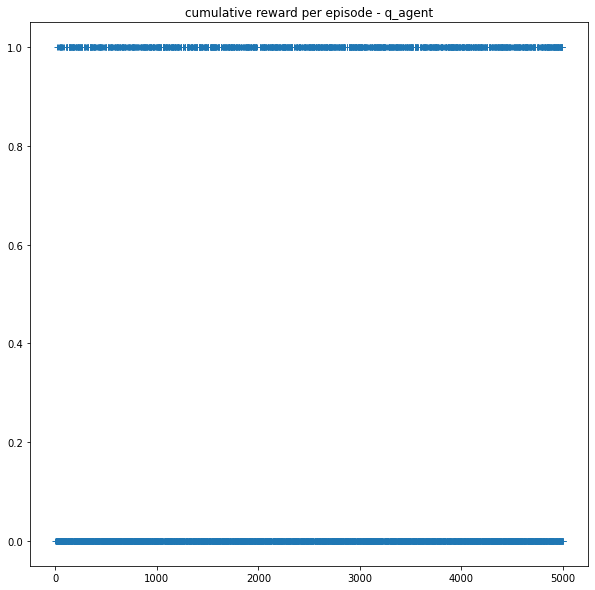

In [35]:
q_agent = MyQAgent(env)
rewards = run_experiment_episode_train(env, q_agent, 5000)
fig,ax = plt.subplots(figsize=(10,10))
ax.plot(rewards,'+')
ax.set_title('cumulative reward per episode - q_agent')

In [36]:
q_agent.policy

array([[0.925, 0.025, 0.025, 0.025],
       [0.025, 0.025, 0.025, 0.925],
       [0.025, 0.025, 0.025, 0.925],
       [0.025, 0.025, 0.025, 0.925],
       [0.925, 0.025, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.025, 0.025, 0.925, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.025, 0.025, 0.025, 0.925],
       [0.025, 0.925, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.025, 0.025, 0.925, 0.025],
       [0.025, 0.025, 0.025, 0.925],
       [0.925, 0.025, 0.025, 0.025]])

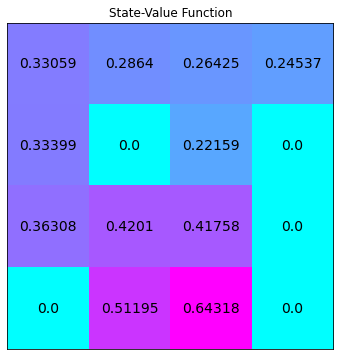

In [37]:
V = policy_evaluation(env, q_agent.policy)
plot_values_lake(V)

In [38]:
V.sum()

4.038063463122946

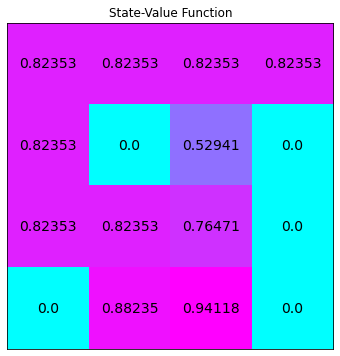

8.882351322605881

In [39]:
policy_best, V_best = value_iteration(env)
plot_values_lake(V_best)
V_best.sum()

In [40]:
#Question: Why we don't have the optimal policy?

In [41]:
q_agent.policy

array([[0.925, 0.025, 0.025, 0.025],
       [0.025, 0.025, 0.025, 0.925],
       [0.025, 0.025, 0.025, 0.925],
       [0.025, 0.025, 0.025, 0.925],
       [0.925, 0.025, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.025, 0.025, 0.925, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.025, 0.025, 0.025, 0.925],
       [0.025, 0.925, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.025, 0.025, 0.925, 0.025],
       [0.025, 0.025, 0.025, 0.925],
       [0.925, 0.025, 0.025, 0.025]])

In [42]:
q_policy_no_eps = np.zeros(q_agent.policy.shape)
q_policy_no_eps[np.arange(len(q_policy_no_eps)), q_agent.policy.argmax(axis=1)] = 1

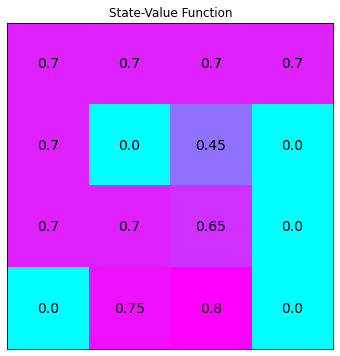

8.882351322605881

In [43]:
V = policy_evaluation(env, q_policy_no_eps)
plot_values_lake(V)
V_best.sum()

In [44]:
q_policy_no_eps

array([[1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.]])

# Use what you built

In [ ]:
# train/test your agent in other discrete action-space env https://gym.openai.com/envs/#toy_text

In [11]:
env = gym.make('Blackjack-v1')
env = gym.make('Taxi-v3')

### keep in mind:
\begin{aligned}
MDP \rightarrow V(S_t) &\leftarrow \mathbb{E}[R_{t+1} + \gamma V(S_{t+1})] \\
MC \rightarrow V(S_t) &\leftarrow V(S_t) + \alpha (G_t - V(S_{t+1})\\
TD \rightarrow V(S_t) &\leftarrow V(S_t) + \alpha (R_{t+1} + \gamma V(S_{t+1}) - V(S_t))
\end{aligned}